# Evaluation of the ArgSum Systems

## Import packages

In [2]:
#######################
### Import packages ###
#######################
import json
import os
from itertools import product
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from argsum import load_test_df, get_soft_scores, match_scorer_cov_eval, llm_cov_eval, llm_red_eval

##########################
### Set plt parameters ###
##########################
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

#################
### Load data ###
#################
ArgKP21 = load_test_df('ArgKP21')
Debate_test = load_test_df('Debate_test')

#############################
### Define functions data ###
#############################

def eval_classification_sum(df, classification_sums_dict, output_dir = 'investigations/4_automatic_evaluation', file_name = None):

    if 'key_point' in df.columns:
        arg_sum_col = 'key_point'
    elif 'summary' in df.columns:
        arg_sum_col = 'summary'

    topics = df['topic'].unique()
    stances = [str(stance) for stance in df['stance'].unique()]
    
    parameter_names = classification_sums_dict['parameter_names']
    parameter_values = classification_sums_dict['parameter_values']
         
    results = dict(zip(['scores', 'parameter_names', 'parameter_values'], [dict(zip(topics, [dict(zip(stances, [dict(zip([str(comb) for comb in list(product(*parameter_values))], [dict(zip(['bert_score_p', 'bart_score_parabank_rs', 'coverage_score', 'llm_coverage', 'llm_redundancy', 'runtime'], [None, None, None, None, None, None])) for i in range(len(list(product(*parameter_values))))])) for i in range(len(stances))])) for i in range(len(topics))])) for i in range(len(['scores']))] + [parameter_names, parameter_values]))

    match_scorer = torch.load('models/match_scorer/cross_encoder/roberta_np/2024-Feb-20_08-20-28/best_model.pt').to('mps')
    
    # Iterate over topics and stances
    for topic_stance in tqdm([(topic, stance) for topic in topics for stance in stances], leave = True, desc = 'topic + stance'):
        
        topic = topic_stance[0]
        stance = topic_stance[1]

        refs_mask = (df['topic'] == topic) & (df['stance'] == int(stance))
        reference = df[refs_mask][arg_sum_col].unique()

        # Iterate over parameters
        for comb in tqdm(list(product(*parameter_values)), leave = True, desc = 'parameter'):

            sums = list(classification_sums_dict['summaries'][str(comb)][topic][stance]['sums'].values())
            soft_scores = get_soft_scores(reference = reference, candidate = sums, similarity_functions = ['bert_score_p', 'bart_score_parabank_rs'])
            coverage_score = match_scorer_cov_eval(reference = reference, candidate = sums, match_scorer = match_scorer, threshold = 0.6)
            llm_cov_score = llm_cov_eval(reference = reference, candidate = sums, temperature = 0.6)
            llm_red_score = llm_red_eval(reference = reference, candidate = sums, temperature = 0.5)


            results['scores'][topic][stance][str(comb)]['bert_score_p'] = soft_scores['bert_score_p']['sR']
            results['scores'][topic][stance][str(comb)]['bart_score_parabank_rs'] = soft_scores['bart_score_parabank_rs']['sR']
            results['scores'][topic][stance][str(comb)]['coverage_score'] = coverage_score
            results['scores'][topic][stance][str(comb)]['llm_coverage'] = llm_cov_score
            results['scores'][topic][stance][str(comb)]['llm_redundancy'] = llm_red_score
            results['scores'][topic][stance][str(comb)]['runtime'] = classification_sums_dict['summaries'][str(comb)][topic][stance]['runtime']


    ########################
    ### Save results #######
    ########################

    if file_name != None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with open(output_dir + '/' + file_name, 'w') as file:
            json.dump(results, file)
    
    return results

def get_best_classification_sum(file_names, dir, c_r = 0.5):
    llm_coverage_system = []
    llm_redundancy_system = []
    llm_weighted_system = []       
    runtime_system = []

    for file_name in file_names:

        with open(dir + '/' + file_name) as f:
            
            classification_sums_dict = json.load(f)
            topics = list(classification_sums_dict['scores'].keys())
            stances = list(classification_sums_dict['scores'][topics[0]].keys())
            params =  list(classification_sums_dict['scores'][topics[0]][stances[0]].keys())

            llm_weighted_top_sta = []
            llm_coverage_top_sta = []
            llm_redundancy_top_sta = []
            runtime_top_sta = []   

            for topic in topics:
                for stance in stances:
                    
                    llm_coverage = []
                    llm_redundancy = []
                    runtime = []        

                    for param in params:

                        llm_coverage.append(classification_sums_dict['scores'][topic][stance][param]['llm_coverage'])
                        llm_redundancy.append(classification_sums_dict['scores'][topic][stance][param]['llm_redundancy'])
                        runtime.append(classification_sums_dict['scores'][topic][stance][param]['runtime'])

                    llm_weighted_top_sta.append(max([(c_r) * llm_coverage[i] + (1-c_r) * (1 - llm_redundancy[i]) for i in range(len(llm_coverage))]))
                    idx = np.argmax([(c_r) * llm_coverage[i] + (1-c_r) * (1 - llm_redundancy[i]) for i in range(len(llm_coverage))]) 

                    llm_coverage_top_sta.append(llm_coverage[idx])
                    llm_redundancy_top_sta.append(llm_redundancy[idx])
                    runtime_top_sta.append(runtime[idx])
            
            llm_weighted_system.append(llm_weighted_top_sta)  
            llm_coverage_system.append(llm_coverage_top_sta)
            llm_redundancy_system.append(llm_redundancy_top_sta) 
            runtime_system.append(runtime_top_sta)
    
    return llm_weighted_system

def eval_clustering_sum(df, clustering_sums_dict, output_dir = 'investigations/4_automatic_evaluation', file_name = None):

    if 'key_point' in df.columns:
        arg_sum_col = 'key_point'
    elif 'summary' in df.columns:
        arg_sum_col = 'summary'

    topics = df['topic'].unique()
    stances = [str(stance) for stance in df['stance'].unique()]
    parameter_names = clustering_sums_dict['clu_parameter_values'] # Hier ist etwas schief gelaufen bei der Zuordnung
    parameter_values = clustering_sums_dict['sum_parameter_names']       
    
    results = dict(zip(['scores', 'parameter_names', 'parameter_values'], [dict(zip(topics, [dict(zip(stances, [dict(zip([str(comb) for comb in list(product(*parameter_values))], [dict(zip(['bert_score_p', 'bart_score_parabank_rs', 'coverage_score', 'llm_coverage', 'llm_redundancy', 'runtime'], [None, None, None, None, None, None])) for i in range(len(list(product(*parameter_values))))])) for i in range(len(stances))])) for i in range(len(topics))])) for i in range(len(['scores']))] + [parameter_names, parameter_values]))
    match_scorer = torch.load('models/match_scorer/cross_encoder/roberta_np/2024-Feb-20_08-20-28/best_model.pt').to('mps')
    
    # Iterate over topics and stances
    for topic_stance in tqdm([(topic, stance) for topic in topics for stance in stances], leave = True, desc = 'topic + stance'):
        
        topic = topic_stance[0]
        stance = topic_stance[1]

        refs_mask = (df['topic'] == topic) & (df['stance'] == int(stance))
        reference = df[refs_mask][arg_sum_col].unique()

        # Iterate over parameters
        for comb in tqdm(list(product(*parameter_values)), leave = True, desc = 'parameter'):
            
            sumss = clustering_sums_dict['summaries'][str(comb)][topic][stance]['()']['sums']

            if sumss != None:
                try:
                    if type(list(sumss.values())[0]) == list:
                        sums = [sum[0] for sum in list(sumss.values())]
                    else:
                        sums = list(sumss.values())
                    soft_scores = get_soft_scores(reference = reference, candidate = sums, similarity_functions = ['bert_score_p', 'bart_score_parabank_rs'])
                    coverage_score = match_scorer_cov_eval(reference = reference, candidate = sums, match_scorer = match_scorer, threshold = 0.6)
                    llm_cov_score = llm_cov_eval(reference = reference, candidate = sums, temperature = 0.6)
                    llm_red_score = llm_red_eval(reference = reference, candidate = sums, temperature = 0.5)


                    results['scores'][topic][stance][str(comb)]['bert_score_p'] = soft_scores['bert_score_p']['sR']
                    results['scores'][topic][stance][str(comb)]['bart_score_parabank_rs'] = soft_scores['bart_score_parabank_rs']['sR']
                    results['scores'][topic][stance][str(comb)]['coverage_score'] = coverage_score
                    results['scores'][topic][stance][str(comb)]['llm_coverage'] = llm_cov_score
                    results['scores'][topic][stance][str(comb)]['llm_redundancy'] = llm_red_score
                    results['scores'][topic][stance][str(comb)]['runtime'] = clustering_sums_dict['summaries'][str(comb)][topic][stance]['()']['runtime']
                except:
                    del results['scores'][topic][stance][str(comb)]

            else:
                del results['scores'][topic][stance][str(comb)]

    ########################
    ### Save results #######
    ########################

    if file_name != None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with open(output_dir + '/' + file_name, 'w') as file:
            json.dump(results, file)
    
    return results

def get_best_classification_sum(file_names, dir, c_r = (2/3),  score_1 = 'llm_coverage', score_2 = 'llm_redundancy',):
    llm_coverage_system = []
    llm_redundancy_system = []
    llm_weighted_system = []       
    runtime_system = []

    for file_name in file_names:

        with open(dir + '/' + file_name) as f:
            
            classification_sums_dict = json.load(f)
            topics = list(classification_sums_dict['scores'].keys())
            stances = list(classification_sums_dict['scores'][topics[0]].keys())
            params =  list(classification_sums_dict['scores'][topics[0]][stances[0]].keys())

            llm_weighted_top_sta = []
            llm_coverage_top_sta = []
            llm_redundancy_top_sta = []
            runtime_top_sta = []   

            for topic in topics:
                for stance in stances:
                    
                    llm_coverage = []
                    llm_redundancy = []
                    runtime = []        

                    for param in params:
                        try:
                            if (classification_sums_dict['scores'][topic][stance][param][score_1] != None) & (classification_sums_dict['scores'][topic][stance][param][score_2] != None):
                                llm_coverage.append(classification_sums_dict['scores'][topic][stance][param][score_1])
                                llm_redundancy.append(classification_sums_dict['scores'][topic][stance][param][score_2])
                                runtime.append(classification_sums_dict['scores'][topic][stance][param]['runtime'])
                        except:
                            pass
                    llm_weighted_top_sta.append(np.max([(c_r) * llm_coverage[i] + (1-c_r) * (1 - llm_redundancy[i]) for i in range(len(llm_coverage))]))
                    idx = np.argmax([(c_r) * llm_coverage[i] + (1-c_r) * (1 - llm_redundancy[i]) for i in range(len(llm_coverage))]) 

                    llm_coverage_top_sta.append(llm_coverage[idx])
                    llm_redundancy_top_sta.append(llm_redundancy[idx])
                    runtime_top_sta.append(runtime[idx])
            
            llm_weighted_system.append(llm_weighted_top_sta)  
            llm_coverage_system.append(llm_coverage_top_sta)
            llm_redundancy_system.append(llm_redundancy_top_sta) 
            runtime_system.append(runtime_top_sta)
    
    return llm_weighted_system, llm_coverage_system, llm_redundancy_system, runtime_system

/Users/moritz/miniconda3/envs/AM/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/moritz/miniconda3/envs/AM/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
loading configuration file config.json from cache at /Users/moritz/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMa

## Classification-based Systems

In [ ]:
dir = 'investigations/3_classification_summaries'
file_names = ['ArgKP21_BarH_Candidates.json', 'ArgKP21_BarH_Key_Points.json', 'ArgKP21_BarH.json',
              'ArgKP21_SMatchToPr_Candidates.json', 'ArgKP21_SMatchToPr_Key_Points.json', 'ArgKP21_SMatchToPr.json']

for file_name in file_names:
    with open(dir + '/' + file_name) as f:
        classification_sums_dict = json.load(f)
    if file_name[0] == 'A':
        df = ArgKP21
    else:
        df = Debate_test

    results = eval_classification_sum(df = ArgKP21,
                                      classification_sums_dict = classification_sums_dict,
                                      file_name = file_name)

In [ ]:
dir = 'investigations/3_classification_summaries'
file_names = ['Debate_test_BarH_Candidates.json', 'Debate_test_BarH_Key_Points.json', 'Debate_test_BarH.json',
              'Debate_test_SMatchToPr_Candidates.json', 'Debate_test_SMatchToPr_Key_Points.json', 'Debate_test_SMatchToPr.json']

for file_name in file_names:
    with open(dir + '/' + file_name) as f:
        classification_sums_dict = json.load(f)
    if file_name[0] == 'A':
        df = ArgKP21
    else:
        df = Debate_test

    results = eval_classification_sum(df = Debate_test,
                                      classification_sums_dict = classification_sums_dict,
                                      file_name = file_name)

## Clustering-based Systems

In [ ]:
dir = 'investigations/2_cluster_summaries'
file_names = ['ArgKP21_Summetix.json', 'ArgKP21_USKPM.json', 'ArgKP21_MCArgSum_SBERT_all_mpnet_base_local.json', 'ArgKP21_MCArgSum_SBERT_all_mpnet_base_global.json']

for file_name in file_names:
    with open(dir + '/' + file_name) as f:
        clustering_sums_dict = json.load(f)
    if file_name[0] == 'A':
        df = ArgKP21
    else:
        df = Debate_test

    results = eval_clustering_sum(df = ArgKP21,
                                  clustering_sums_dict = clustering_sums_dict,
                                  file_name = file_name)

In [ ]:
dir = 'investigations/2_cluster_summaries'
file_names = ['Debate_test_Summetix.json', 'Debate_test_USKPM.json', 'Debate_test_MCArgSum_SBERT_all_mpnet_base_local.json', 'Debate_test_MCArgSum_SBERT_all_mpnet_base_global.json']
for file_name in file_names:
    with open(dir + '/' + file_name) as f:
        clustering_sums_dict = json.load(f)
    if file_name[0] == 'A':
        df = ArgKP21
    else:
        df = Debate_test

    results = eval_clustering_sum(df = Debate_test,
                                  clustering_sums_dict = clustering_sums_dict,
                                  file_name = file_name)

## Results

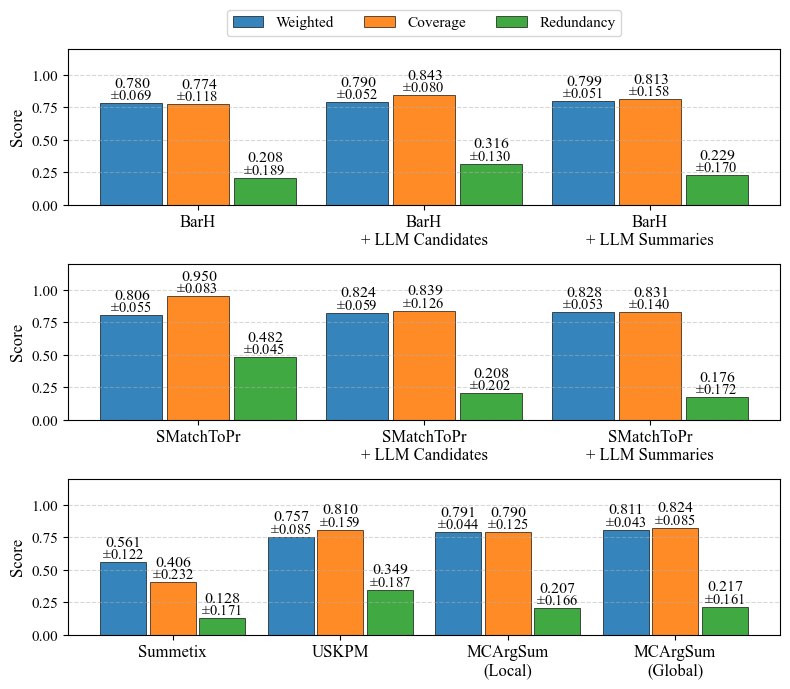

In [8]:
runtime_mean = []
runtime_std = []

c_r = (2/3)
score_1 = 'llm_coverage'
data = 'ArgKP21'

dir = 'investigations/4_automatic_evaluation'
file_names = ['_BarH.json', '_BarH_Candidates.json', '_BarH_Key_Points.json']
file_names = [data + file_name for file_name in file_names]

x = ['BarH', 'BarH\n+ LLM Candidates', 'BarH\n+ LLM Summaries']

cols = ['tab:blue', 'tab:orange', 'tab:green']
x_ticks = [[0, 2+0.2, 4+0.4], [0.65, 2.65+0.2, 4.65+0.4], [1.3, 3.3+0.2, 5.3+0.4]]

plt.figure(figsize=(8,7))

plt.subplot(3,1,1)

llm_weighted_system, llm_coverage_system, llm_redundancy_system, runtime_system = get_best_classification_sum(file_names, dir, c_r = c_r, score_1 = score_1)
runtime_mean += np.mean(runtime_system, axis = 1).tolist()
runtime_std += np.std(runtime_system, axis = 1).tolist()

for i in range(0,3):
     y = np.mean(llm_weighted_system, axis = 1)[i]
     std = np.std(llm_weighted_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Weighted')
     else:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)  
     plt.text(x_ticks[0][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[0][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_coverage_system, axis = 1)[i]
     std = np.std(llm_coverage_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Coverage')
     else:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[1][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[1][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_redundancy_system, axis = 1)[i]
     std =  np.std(llm_redundancy_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Redundancy')
     else:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[2][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[2][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = x_ticks[1], labels = x, fontsize = 12)
plt.yticks(fontsize = 11)
plt.ylabel('Score', fontsize = 12)
plt.ylim(0,1.2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol = 3, fontsize = 11, fancybox = True)

plt.subplot(3,1,2)

dir = 'investigations/4_automatic_evaluation'
file_names = ['_SMatchToPr.json', '_SMatchToPr_Candidates.json', '_SMatchToPr_Key_Points.json']
file_names = [data + file_name for file_name in file_names]

x = ['SMatchToPr', 'SMatchToPr\n+ LLM Candidates', 'SMatchToPr\n+ LLM Summaries']

cols = ['tab:blue', 'tab:orange', 'tab:green']
x_ticks = [[0, 2+0.2, 4+0.4], [0.65, 2.65+0.2, 4.65+0.4], [1.3, 3.3+0.2, 5.3+0.4]]

llm_weighted_system, llm_coverage_system, llm_redundancy_system, runtime_system = get_best_classification_sum(file_names, dir, c_r = c_r, score_1 = score_1)
runtime_mean += np.mean(runtime_system, axis = 1).tolist()
runtime_std += np.std(runtime_system, axis = 1).tolist()

for i in range(0,3):
     y = np.mean(llm_weighted_system, axis = 1)[i]
     std = np.std(llm_weighted_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Weighted')
     else:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)  
     plt.text(x_ticks[0][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[0][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_coverage_system, axis = 1)[i]
     std = np.std(llm_coverage_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Coverage')
     else:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[1][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[1][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_redundancy_system, axis = 1)[i]
     std =  np.std(llm_redundancy_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Redundancy')
     else:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[2][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[2][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = x_ticks[1], labels = x, fontsize = 12)
plt.yticks(fontsize = 11)
plt.ylabel('Score', fontsize = 12)
plt.ylim(0,1.2)


plt.subplot(3,1,3)
dir = 'investigations/4_automatic_evaluation'
file_names = ['_Summetix.json', '_USKPM.json', '_MCArgSum_SBERT_all_mpnet_base_local.json', '_MCArgSum_SBERT_all_mpnet_base_global.json']
file_names = [data + file_name for file_name in file_names]

x = ['Summetix', 'USKPM', 'MCArgSum\n(Local)', 'MCArgSum\n(Global)']

cols = ['tab:blue', 'tab:orange', 'tab:green']
x_ticks = [[0,2+0.2,4+0.4,6+0.6], [0.65, 2.65+0.2, 4.65+0.4, 6.65+0.6], [1.3,3.3+0.2,5.3+0.4,7.3+0.6]]

llm_weighted_system, llm_coverage_system, llm_redundancy_system, runtime_system = get_best_classification_sum(file_names, dir, c_r = c_r, score_1 = score_1)
runtime_mean += np.mean(runtime_system, axis = 1).tolist()
runtime_std += np.std(runtime_system, axis = 1).tolist()

for i in range(0,4):
     y = np.mean(llm_weighted_system, axis = 1)[i]
     std = np.std(llm_weighted_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Weighted')
     else:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)  
     plt.text(x_ticks[0][i] - 0.155 - 0.075, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[0][i] - 0.2 - 0.075, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_coverage_system, axis = 1)[i]
     std = np.std(llm_coverage_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Coverage')
     else:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[1][i] - 0.155 - 0.075, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[1][i] - 0.2 - 0.075, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_redundancy_system, axis = 1)[i]
     std =  np.std(llm_redundancy_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Redundancy')
     else:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[2][i] - 0.155 - 0.075, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[2][i] - 0.2 - 0.075, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = x_ticks[1], labels = x, fontsize = 12)
plt.yticks(fontsize = 11)
plt.ylabel('Score', fontsize = 12)
plt.ylim(0,1.2)

plt.tight_layout()
plt.show()

In [9]:
pd.DataFrame([runtime_mean, runtime_std], index = ['Runtime', 'Std'], columns = ['BarH', 'LLM Candidates', 'LLM Summaries', 'SMatchToPr', 'LLM Candidates', 'LLM Summaries', 'Summetix', 'USKPM', 'MCArgSum (local)', 'MCArgSum (global)']).T.round(3)

,Runtime,Std
BarH,26.533,13.078
LLM Candidates,24.917,5.758
LLM Summaries,5.480,1.297
SMatchToPr,16.717,3.150
LLM Candidates,8.706,0.546
LLM Summaries,4.962,0.711
Summetix,1.782,0.275
USKPM,6.366,1.994
MCArgSum (local),4.044,1.400
MCArgSum (global),3.568,1.539


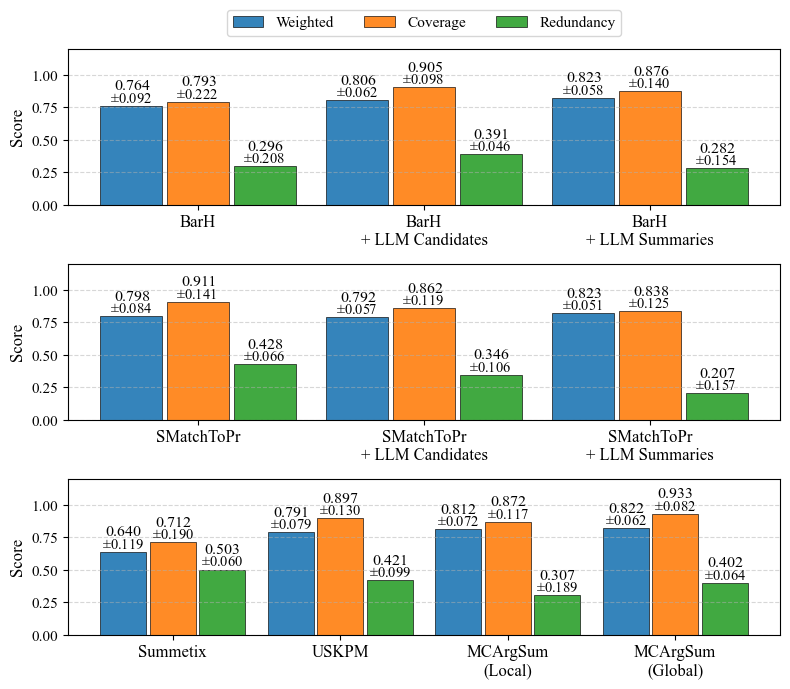

In [10]:
runtime_mean = []
runtime_std = []

c_r = (2/3)
score_1 = 'llm_coverage'
data = 'Debate_test'

dir = 'investigations/4_automatic_evaluation'
file_names = ['_BarH.json', '_BarH_Candidates.json', '_BarH_Key_Points.json']
file_names = [data + file_name for file_name in file_names]

x = ['BarH', 'BarH\n+ LLM Candidates', 'BarH\n+ LLM Summaries']

cols = ['tab:blue', 'tab:orange', 'tab:green']
x_ticks = [[0, 2+0.2, 4+0.4], [0.65, 2.65+0.2, 4.65+0.4], [1.3, 3.3+0.2, 5.3+0.4]]

plt.figure(figsize=(8,7))

plt.subplot(3,1,1)

llm_weighted_system, llm_coverage_system, llm_redundancy_system, runtime_system = get_best_classification_sum(file_names, dir, c_r = c_r, score_1 = score_1)
runtime_mean += np.mean(runtime_system, axis = 1).tolist()
runtime_std += np.std(runtime_system, axis = 1).tolist()

for i in range(0,3):
     y = np.mean(llm_weighted_system, axis = 1)[i]
     std = np.std(llm_weighted_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Weighted')
     else:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)  
     plt.text(x_ticks[0][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[0][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_coverage_system, axis = 1)[i]
     std = np.std(llm_coverage_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Coverage')
     else:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[1][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[1][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_redundancy_system, axis = 1)[i]
     std =  np.std(llm_redundancy_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Redundancy')
     else:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[2][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[2][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = x_ticks[1], labels = x, fontsize = 12)
plt.yticks(fontsize = 11)
plt.ylabel('Score', fontsize = 12)
plt.ylim(0,1.2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol = 3, fontsize = 11, fancybox = True)

plt.subplot(3,1,2)

dir = 'investigations/4_automatic_evaluation'
file_names = ['_SMatchToPr.json', '_SMatchToPr_Candidates.json', '_SMatchToPr_Key_Points.json']
file_names = [data + file_name for file_name in file_names]

x = ['SMatchToPr', 'SMatchToPr\n+ LLM Candidates', 'SMatchToPr\n+ LLM Summaries']

cols = ['tab:blue', 'tab:orange', 'tab:green']
x_ticks = [[0, 2+0.2, 4+0.4], [0.65, 2.65+0.2, 4.65+0.4], [1.3, 3.3+0.2, 5.3+0.4]]

llm_weighted_system, llm_coverage_system, llm_redundancy_system, runtime_system = get_best_classification_sum(file_names, dir, c_r = c_r, score_1 = score_1)
runtime_mean += np.mean(runtime_system, axis = 1).tolist()
runtime_std += np.std(runtime_system, axis = 1).tolist()

for i in range(0,3):
     y = np.mean(llm_weighted_system, axis = 1)[i]
     std = np.std(llm_weighted_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Weighted')
     else:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)  
     plt.text(x_ticks[0][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[0][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_coverage_system, axis = 1)[i]
     std = np.std(llm_coverage_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Coverage')
     else:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[1][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[1][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_redundancy_system, axis = 1)[i]
     std =  np.std(llm_redundancy_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Redundancy')
     else:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[2][i] - 0.155 - 0.01, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[2][i] - 0.2 - 0.01, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = x_ticks[1], labels = x, fontsize = 12)
plt.yticks(fontsize = 11)
plt.ylabel('Score', fontsize = 12)
plt.ylim(0,1.2)


plt.subplot(3,1,3)
dir = 'investigations/4_automatic_evaluation'
file_names = ['_Summetix.json', '_USKPM.json', '_MCArgSum_SBERT_all_mpnet_base_local.json', '_MCArgSum_SBERT_all_mpnet_base_global.json']
file_names = [data + file_name for file_name in file_names]

x = ['Summetix', 'USKPM', 'MCArgSum\n(Local)', 'MCArgSum\n(Global)']

cols = ['tab:blue', 'tab:orange', 'tab:green']
x_ticks = [[0,2+0.2,4+0.4,6+0.6], [0.65, 2.65+0.2, 4.65+0.4, 6.65+0.6], [1.3,3.3+0.2,5.3+0.4,7.3+0.6]]

llm_weighted_system, llm_coverage_system, llm_redundancy_system, runtime_system = get_best_classification_sum(file_names, dir, c_r = c_r, score_1 = score_1)
runtime_mean += np.mean(runtime_system, axis = 1).tolist()
runtime_std += np.std(runtime_system, axis = 1).tolist()

for i in range(0,4):
     y = np.mean(llm_weighted_system, axis = 1)[i]
     std = np.std(llm_weighted_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Weighted')
     else:
          bar = plt.bar(x = x_ticks[0][i], width = 0.6, height = y, color = cols[0], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)  
     plt.text(x_ticks[0][i] - 0.155 - 0.075, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[0][i] - 0.2 - 0.075, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_coverage_system, axis = 1)[i]
     std = np.std(llm_coverage_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Coverage')
     else:
          bar = plt.bar(x = x_ticks[1][i], width = 0.6, height = y, color = cols[1], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[1][i] - 0.155 - 0.075, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[1][i] - 0.2 - 0.075, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

     y =  np.mean(llm_redundancy_system, axis = 1)[i]
     std =  np.std(llm_redundancy_system, axis = 1)[i]
     if i == 0:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'Redundancy')
     else:
          bar = plt.bar(x = x_ticks[2][i], width = 0.6, height = y, color = cols[2], edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
     plt.text(x_ticks[2][i] - 0.155 - 0.075, y+0.11+0.01, f'{np.round(y, 3)}00'[0:5], fontsize = 11.5)
     plt.text(x_ticks[2][i] - 0.2 - 0.075, y+0.015+0.01, r'$\pm$' + f'{np.round(std, 3)}00'[0:5], fontsize = 10.5)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = x_ticks[1], labels = x, fontsize = 12)
plt.yticks(fontsize = 11)
plt.ylabel('Score', fontsize = 12)
plt.ylim(0,1.2)

plt.tight_layout()
plt.show()

In [11]:
pd.DataFrame([runtime_mean, runtime_std], index = ['Runtime', 'Std'], columns = ['BarH', 'LLM Candidates', 'LLM Summaries', 'SMatchToPr', 'LLM Candidates', 'LLM Summaries', 'Summetix', 'USKPM', 'MCArgSum (local)', 'MCArgSum (global)']).T.round(3)

,Runtime,Std
BarH,117.822,110.259
LLM Candidates,68.384,42.868
LLM Summaries,18.411,11.432
SMatchToPr,15.090,7.054
LLM Candidates,10.949,3.181
LLM Summaries,6.337,1.460
Summetix,4.015,1.255
USKPM,30.523,16.047
MCArgSum (local),7.629,2.971
MCArgSum (global),4.832,1.310


## Additional Human Evaluation for Debate: Correlation with automatic scores

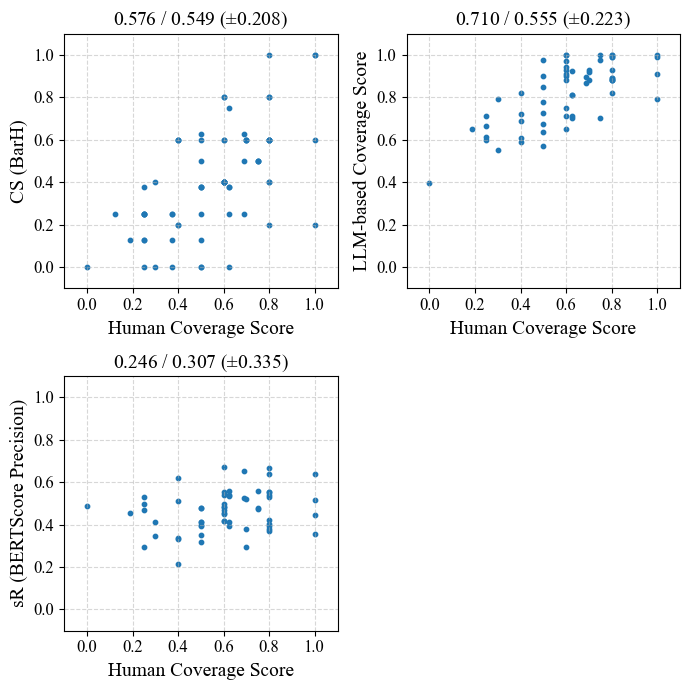

In [9]:
df = pd.read_csv('investigations/0_human_evaluation_argkp21/Debate.csv').sort_values(['topic', 'stance'])

i = 72
plt.figure(figsize=(7,7))

plt.subplot(2,2,1)
plt.scatter(df.human_scores.to_list()[:i], df.coverage_score.to_list()[:i], s=10)
covs_1 = []
for i in range(0,72,12):
    covs_1.append(np.corrcoef(df.human_scores.to_list()[i:i+12], df.coverage_score.to_list()[i:i+12])[0][1])
plt.title(f'{np.round(np.corrcoef(df.human_scores.to_list()[:i], df.coverage_score.to_list()[:i])[0][1],3)} / {np.round(np.mean(covs_1),3)} ($\pm${np.round(np.std(covs_1),3)})', fontsize = 14)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks(ticks = [i for i in np.arange(0,1.1,0.2)], fontsize = 12)
plt.yticks(ticks = [i for i in np.arange(0,1.1,0.2)], fontsize = 12)
plt.xlabel('Human Coverage Score', fontsize = 14)
plt.ylabel('CS (BarH)', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.5)


plt.subplot(2,2,2)
plt.scatter(df.human_scores.to_list()[:i], df.llm_coverage.to_list()[:i], s=10)
covs_1 = []
for i in range(0,72,12):
    covs_1.append(np.corrcoef(df.human_scores.to_list()[i:i+12], df.llm_coverage.to_list()[i:i+12])[0][1])
plt.title(f'{np.round(np.corrcoef(df.human_scores.to_list()[:i], df.llm_coverage.to_list()[:i])[0][1],3)}0 / {np.round(np.mean(covs_1),3)} ($\pm${np.round(np.std(covs_1),3)})', fontsize = 14)
plt.xticks(ticks = [i for i in np.arange(0,1.1,0.2)], fontsize = 12)
plt.yticks(ticks = [i for i in np.arange(0,1.1,0.2)], fontsize = 12)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel('Human Coverage Score', fontsize = 14)
plt.ylabel('LLM-based Coverage Score', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.5)

plt.subplot(2,2,3)
plt.scatter(df.human_scores.to_list()[:i], df.bert_score_p.to_list()[:i], s=10)
covs_1 = []
for i in range(0,72,12):
    covs_1.append(np.corrcoef(df.human_scores.to_list()[i:i+12], df.bert_score_p.to_list()[i:i+12])[0][1])
plt.title(f'{np.round(np.corrcoef(df.human_scores.to_list()[:i], df.bert_score_p.to_list()[:i])[0][1],3)} / {np.round(np.mean(covs_1),3)} ($\pm${np.round(np.std(covs_1),3)})', fontsize = 14)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks(ticks = [i for i in np.arange(0,1.1,0.2)], fontsize = 12)
plt.yticks(ticks = [i for i in np.arange(0,1.1,0.2)], fontsize = 12)
plt.grid(linestyle = '--', alpha = 0.5)
plt.xlabel('Human Coverage Score', fontsize = 14)
plt.ylabel('sR (BERTScore Precision)', fontsize = 14)


plt.tight_layout()

plt.show()